# Digital House - Data Science a Distancia

## Trabajo Práctico 2

Entrenamos un modelo predictor de precio de propiedades. 
Basado en [valuador de Properati](https://www.properati.com.ar/tools/valuador-propiedades).

### Autores: Daniel Borrino, Ivan Mongi, Jessica Polakoff, Julio Tentor
<p style="text-align:right;">Mayo 2022</p>

#### Aspectos técnicos
La notebook se ejecuta correctamente en una instalación estándar de Anaconda versión 4.11.0 build  3.21.6, Python 3.9.7


<div class="alert alert-warning" role="alert">
<b>1) Read: Lectura Data Set</b> 
</div>

#### Librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
#Levantando el csv
data_url = "../Data/properatti.csv"
data = pd.read_csv(data_url, encoding="utf-8")

<div class="alert alert-warning" role="alert">
<b>2)Preprocess: Generación de Dataset final</b> 
</div>

#### Eliminamos los valores nulos de la variable Target

In [4]:
#Renombramos algunas columnas para facilitar la manipulacion
data.rename(columns={'property_type' : 'tipo', 'price_aprox_usd' : 'precio','surface_covered_in_m2' : 'sup'}, inplace=True)

In [5]:
#Limpiamos los NaN en el precio y en superficie
data_clean = data.dropna(axis=0, how='any', subset=['precio', 'sup']).copy()

#### Seleccionamos solo los state_name con mayor numero de registros

In [6]:
#Seleccionamos los primeros 6 valores (incluyen los 4 mínimos solicitados, + 2 de yapa)
iterar_state = data_clean['state_name'].value_counts().head(6)
iterar_state = iterar_state.index

#dropeamos los state_name diferentes.
data_clean['state_name'] = [x if x in iterar_state else np.NaN for x in data_clean['state_name']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['state_name']).copy()

#### Seleccionamos solo Departamento, Casa y PH

In [7]:
#Seleccionamos solo Departamento, Casa y PH
iterar_tipo = data_clean['tipo'].value_counts().head(3)
iterar_tipo = iterar_tipo.index

#dropeamos todos los state name con pocos registros
data_clean['tipo'] = [x if x in iterar_tipo else np.NaN for x in data_clean['tipo']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['tipo']).copy()

#### Seleccionamos solo Lugares con muchas observaciones

In [8]:
#Seleccionamos solo Lugares con muchas observaciones (arbitrario, probamos varios y elegimos el que mejor resultado daba)
iterar_place = data_clean['place_name'].value_counts()[data_clean['place_name'].value_counts()>200]
iterar_place = iterar_place.index

#Definimos como "otro" todas aquellas observaciones que no coincidan con interar_place.
data_clean['place_name'] = [x if x in iterar_place else np.NaN for x in data_clean['place_name']]
data_clean = data_clean.dropna(axis=0, how='any', subset=['place_name']).copy()

#### Eliminamos Outliers para las variables que vamos a correlacionar: 

In [9]:
#funcion para borrar outliers.
def borrar_outliers(data, columnas):
    u"""Solo recibe columnas con valores numericos. 
    Data: dataset a analizar
    Columnas: columnas donde borrar outliers. Deben ser una tupla"""
    cols_limpiar = columnas
    mask=np.ones(shape=(data.shape[0]), dtype=bool)

    for i in cols_limpiar:
        
        #calculamos cuartiles, y valores de corte segun RSI
        Q1=data[i].quantile(0.25)
        Q3=data[i].quantile(0.75)
        RSI=Q3-Q1
        max_value=Q3+1.5*RSI
        min_value=Q1-1.5*RSI
        
        #Consideraciones extras a la hora de ajustar valores mínimos
            # No puede ser negativo.
            # No puede estar fuera del boxplot para outliers
            # Criterio experto se decide dejar desde el 5% hacia adelante.
            # Además, no consideraremos los que tienen menos de 15m2 o menos de USD1000.
        if i=='precio':
            min_value=max(data[i].quantile(0.05), min_value, 1000)
        else: 
            min_value=max(data[i].quantile(0.05), min_value, 15)
        
        #Dejamos afuera de la regresión aquellas propiedades mas caras que 1.5 M de USD. 
        max_value=(min(data[i].quantile(0.95), max_value, 1500000))
        
        #filtramos por max y min
        mask=np.logical_and(mask, np.logical_and(data[i]>=min_value, data[i]<=max_value))
    return data[mask]

In [10]:
# serie para determinar observaciones sin outliers para precio en dólares y superficie cubierta
data_clean['tidy1'] = np.NaN

for tipo in iterar_tipo:
    for place in iterar_place:
        # selecciono por lugar y tipo
        mask = np.logical_and(data_clean['place_name']==place, data_clean['tipo']==tipo)
        # calcula outliers y los suprime
        data_ok = borrar_outliers(data_clean[mask], ('precio', 'sup'))
        # determina observaciones válidas
        data_clean.loc[data_ok.index, 'tidy1'] = True

# probablemente esto se pueda hacer con algún método específico de pandas...

In [11]:
# suprimimos las observaciones que no estan "tidy": son aquellas con outliers o valores ilogicos.
data_clean = data_clean.dropna(axis=0, how='any', subset=['tidy1'])

---
#### Creacion de nuevas variables con valor predictivo:


##### Analisis para Cantidad de ambientes

In [12]:
#Generamos funcion regex para buscar en description.
def regex_to_values(col, reg, not_match=0) :
    u"""Returns a serie with the result of apply the regular expresion to the column
    the serie have a float value only when regular expression search() method found a match
    
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : not_match if x is np.NaN or x is None else float(x.group(1)))

    return serie

In [13]:
#Buscamos cantidad de ambientes
pattern = '([1-2][0-9]?)(?= amb)'
express = re.compile(pattern, flags = re.IGNORECASE)

work = regex_to_values(data_clean['description'], express, 1)

data_clean['ambientes'] = work


In [14]:
#realizamos la imputacion de rooms en ambientes

mask = data_clean['rooms'].notnull()
data_clean.loc[mask, 'ambientes'] = data_clean.loc[mask, 'rooms']

##### Analisis para Cantidad de baños

In [15]:
pattern = '([1-2][0-9]?)(?= baño)'
express = re.compile(pattern, flags = re.IGNORECASE)

work = regex_to_values(data['description'], express, 1)

data_clean['baños'] = work




##### Nos proponemos encontrar amenities

In [16]:
#Generamos funcion regex para buscar en description.
def regex_to_tags(col, reg, match, not_match = np.NaN) :
    u"""Returns a series with 'match' values result of apply the regular expresion to the column
    the 'match' value will be when the regular expression search() method found a match
    the 'not_match' value will be when the regular expression serach() method did not found a match
    col : column where to apply regular expresion
    reg : regular expresion compiled
    """
    
    serie = col.apply(lambda x : x if x is np.NaN else reg.search(x))
    serie = serie.apply(lambda x : match if x is not None else not_match)
   
    return serie

In [17]:
#Buscamos Balcón
pattern = 'balcon|balcón'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['balcon'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [18]:
#Buscamos Cocheras
pattern = 'cochera|garage|auto'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['cochera'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [19]:
#Buscamos Parrillas
pattern = 'parrilla'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['parrilla'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [20]:
#Buscamos Piletas
pattern = 'piscina|pileta'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['pileta'] = regex_to_tags(data_clean['description'], express, 1, 0)



In [21]:
#Buscamos Amoblado
pattern = 'amoblado'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['amoblado'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [22]:
#Buscamos Lavadero
pattern = 'lavadero'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['lavadero'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [23]:
#Buscamos Patio
pattern = 'patio'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['patio'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [24]:
#Buscamos Terraza
pattern = 'terraza'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['terraza'] = regex_to_tags(data_clean['description'], express, 1, 0)


In [25]:
#Buscamos Jardin
pattern = 'jardin'
express = re.compile(pattern, flags = re.IGNORECASE)

data_clean['jardin'] = regex_to_tags(data_clean['description'], express, 1, 0)


##### Ordenamos el data set y generamos los dummies.

In [26]:
# Esto es un relleno de nulos de lat y lon con promedios del barrio. No mejoró el RMSE, así que no se utiliza.
# Lo dejamos operativo en caso de futura necesidad (abajo se dropean las columnas)
grupo_place_name=data_clean.groupby('place_name')
data_clean['lat']=grupo_place_name['lat'].transform(lambda x: x.fillna(x.mean()))
data_clean['lon']=grupo_place_name['lon'].transform(lambda x: x.fillna(x.mean()))

In [27]:
data_clean.reset_index(inplace=True)

In [28]:
data_clean = data_clean.drop(columns=['index', 'Unnamed: 0','operation', 'place_with_parent_names', 
                                      'country_name','geonames_id', 'lat-lon','lat','lon', 'price', 'currency',
                                        'price_aprox_local_currency','floor', 'price_usd_per_m2', 
                                     'price_per_m2', 'rooms', 'expenses', 'properati_url', 'description', 'title', 'image_thumbnail', 'surface_total_in_m2', 
                                      'tidy1'])

In [29]:
data_clean = pd.get_dummies(data=data_clean, columns=['tipo', 'place_name','state_name'], drop_first=True)

##### A continuación, buscamos interacción entre variables. Multiplicamos con ciclos for.

In [30]:
#definimos los amenities encontrados para poder generar variables cruzadas.
amenities= ['balcon', 'cochera', 'parrilla', 'pileta', 'amoblado', 'lavadero', 'patio', 'terraza', 'jardin']

#Amenities contra tipo de propiedad
for a in amenities:
    cat1='tipo_house'+'xx'+a
    data_clean[cat1]=data_clean['tipo_house']*data_clean[a]
    
    cat2='tipo_apartment'+'xx'+a
    data_clean[cat2]=data_clean['tipo_apartment']*data_clean[a]

#superficie contra todo (¡Todo menos precio!)
for b in data_clean.columns:
    if b=="precio":
        continue
    cat3='sup'+'xx'+b
    data_clean[cat3]=data_clean['sup']*data_clean[b]

#Otras features relevantes
data_clean['supxxsupxxsup']=data_clean['sup']**3

    
#La forma de separar las multiplicaciones con 'xx' es para localizarlas despues.

C:\Users\jtentor\AppData\Local\Temp/ipykernel_7816/1429551721.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_clean[cat3]=data_clean['sup']*data_clean[b]
C:\Users\jtentor\AppData\Local\Temp/ipykernel_7816/1429551721.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data_clean['supxxsupxxsup']=data_clean['sup']**3


In [31]:
#generamos data_final
data_final=data_clean.copy()

In [32]:
#Las features es todo lo que no sea precio.
excluir=['precio']
features = data_final.columns.difference(excluir)

<div class="alert alert-warning" role="alert">
<b>3) Split: Dividimos la base en data train y data set.</b> 
</div>

In [33]:
#Separamos en train y test.
data_train, data_test = train_test_split(data_final, test_size=0.35, random_state =200)

In [34]:
# Estandarizamos para estar preparados en caso de overfit y que necesitemos regularizar.
# Usamos solamente el train para estandarizar! Se supone que el test es "desconocido" en este momento.
scaler = StandardScaler()
scaler.fit(data_train[features])

X_train = pd.DataFrame(scaler.transform(data_train[features]), index=data_train[features].index, columns=data_train[features].columns)
y_train = data_train['precio']

X_test = pd.DataFrame(scaler.transform(data_test[features]), index=data_test[features].index, columns=data_test[features].columns)
y_test = data_test['precio']

In [35]:
#Probamos Lasso y Ridge como métodos de regularizacion. Como no encontramos overfit, nos quedamos con LinearRegression.
model = linear_model.LinearRegression()

In [36]:
model.fit(X_train, y_train);

<div class="alert alert-warning" role="alert">
<b>4) Analisis del modelo en train</b> 
</div>

In [37]:
#Revisamos la bondad del ajuste en train
n_train=data_train.shape[0]
r2_train=model.score(X=X_train, y = y_train)
r2_adj_train = 1-(1-r2_train)*((n_train-1)/(n_train-len(features)-1))
precio_est_train=model.predict(X_train)
RMSE_train= np.sqrt(mean_squared_error(y_true=y_train, y_pred=precio_est_train))

print(f'N. features: {len(features)}\nr2_train: {r2_train} \nr2_adj_train: {r2_adj_train} \nRMSE: {RMSE_train} ')

N. features: 227
r2_train: 0.8179632323820196 
r2_adj_train: 0.8167180208030146 
RMSE: 75381.00159560144 


<div class="alert alert-warning" role="alert">
<b>5) Analisis del modelo en test</b> 
</div>

In [38]:
#Revisamos la bondad del ajuste en test
n_test=data_test.shape[0]
r2_test=model.score(X=X_test, y = y_test)
r2_adj_test = 1-(1-r2_test)*((n_test-1)/(n_test-len(features)-1))
precio_est_test=model.predict(X_test)
RMSE_test= np.sqrt(mean_squared_error(y_true=y_test, y_pred=precio_est_test))

print(f'N. features: {len(features)}\nr2_test: {r2_test} \nr2_adj_test: {r2_adj_test} \nRMSE: {RMSE_test} ')

N. features: 227
r2_test: 0.8232718315661334 
r2_adj_test: 0.8210134835457277 
RMSE: 73792.19768757444 


In [39]:
# Analizamos que y_test y y_train sean similares estadisticamente
print(f' Describe de y_train: \n{y_train.describe()}\n\n, Describe de y_test: \n{y_test.describe()}')

 Describe de y_train: 
count    3.341300e+04
mean     2.126581e+05
std      1.766806e+05
min      3.600000e+04
25%      1.000000e+05
50%      1.532000e+05
75%      2.590000e+05
max      1.500000e+06
Name: precio, dtype: float64

, Describe de y_test: 
count    1.799200e+04
mean     2.103640e+05
std      1.755374e+05
min      3.600000e+04
25%      1.000000e+05
50%      1.500000e+05
75%      2.550000e+05
max      1.500000e+06
Name: precio, dtype: float64


##### Vamos a plantear una función que, al llamarla, analice la normalidad de los residuos

In [40]:
import statsmodels.api as sm

def gauss_markov_test(Xtest, ytest):
    u"""
    funcion para visualizar e identificar supuestos de linealidad sobre la regression lineal
    
    Args:
    * Xtest - observerd features
    * ytest - observed values
    """

    model = sm.OLS(ytest, sm.add_constant(Xtest)).fit()
    ypred = model.predict()
    resid = model.resid
    rstud = model.get_influence().resid_studentized_internal
    rsqrt = np.sqrt(np.abs(rstud))

    
    plt.figure(figsize=(16, 6))
    sns.regplot(x=ypred, y=ytest, lowess=True, line_kws={'color': 'red'})
    plt.title('Linealidad de Valores Observados', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Valores Observados', fontdict = {'fontsize': 14})
    plt.show()

    plt.figure(figsize=(16, 6))
    sns.regplot(x = ypred, y = resid, lowess = True, line_kws = {'color': 'red'})
    plt.title('Linealidad de Residuos', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos', fontdict = {'fontsize': 14})
    plt.show()
    
    plt.figure(figsize=(16, 8))
    sns.regplot(x = ypred, y = rsqrt, lowess = True, line_kws = {'color': 'red'})
    plt.title('Scale Location', fontdict = {'fontsize': 18})
    plt.xlabel('Valores Predecidos', fontdict = {'fontsize': 14})
    plt.ylabel('Residuos Normalizados', fontdict = {'fontsize': 14})
    plt.show()

    
    sns.mpl.rcParams['figure.figsize'] = (16, 8)
    fig, ax = plt.subplots(2)

    sm.graphics.tsa.plot_acf(x = resid, ax = ax[0], lags = 40 , alpha = 0.05, title = '')
    ax[0].set_title('Correlación de características', fontdict = {'fontsize': 18})

    plt.subplots_adjust(top=1.5, wspace=2)

    sm.ProbPlot(model.resid).qqplot(ax = ax[1], line = 's')
    ax[1].set_title('Normalidad de los Residuos', fontdict = {'fontsize': 18})
    ax[1].set_xlabel("Valores Teóricos", fontsize = 14)
    ax[1].set_ylabel("Valores Reales", fontsize = 14)
    plt.show()
    
    return

In [41]:
# La siguiente linea de codigo puede activarse para mostrar graficamente la normalidad de los residuos.
# gauss_markov_test(X_test, y_test)

---
#### ¿Y si aplicamos un enfoque estadístico?

##### Ya encontramos un modelo que ajusta bien nuestro dataset en train y en test. Tenemos muchas features, y esto complica un la interpretación de los coeficientes.
##### ¿Qué pasaría si nuestro cliente nos solicitara un modelo mas *explicable*? 
##### Lo que sigue a continuación es un modelo más simple, con menos variables e interacciones. El enfoque utilizado fue eliminar aquellas features que no pasaban un test de hipótesis donde H0 --> coef=0

In [42]:
#Traemos statsmodel para hacer una regresión linear ordinaria.
from statsmodels.regression import linear_model as sm_linear_model
model_sm = sm_linear_model.OLS(y_train, X_train).fit()

#La siguiente linea de codigo puede activarse para mostrar estadística de la regresión.
# model_sm.summary()

In [43]:
#Esto va a descartar todos los features que no cumplan con la condición de p<0.05. 
# Respeta el principio de jerarquia: no elima features base de features combinados relevantes.

#Features con p alto
bad_features = model_sm.pvalues[model_sm.pvalues > 0.1].index

#Excluimos aquellos features combinados. 
excluded_features=[]
for ft in bad_features:
    if ft.find('xx')>=0:
        excluded_features.append(ft)

new_features = features.difference(excluded_features)
        
#Excluimos aquellos features irrelevantes que NO sean base de alguna feature combinada relevante    
for ft in bad_features:
    if ft.find('xx')==-1:
        ft_is_base = False
        for nw in new_features:
            if ((nw.find('xx')>=0) and (ft in nw)):
                ft_is_base=True
        if (not ft_is_base):
            excluded_features.append(ft)

#Generamos una nueva lista de features, sin los excluidos.
new_features = list(features.difference(excluded_features))   

In [44]:
#volvemos a definir los X e y. Ahora usando los nuevos features
X_train_new = X_train[new_features]
y_train_new = y_train

X_test_new = X_test[new_features]
y_test_new = y_test


In [45]:
model.fit(X_train_new, y_train_new);

In [46]:
#Mostramos los features estadisticamente significativos. Son más explicables y "client friendly"
new_features

['place_name_Adrogué',
 'place_name_Barracas',
 'place_name_Barrio Los Alisos',
 'place_name_Belgrano',
 'place_name_Bella Vista',
 'place_name_Benavidez',
 'place_name_Boedo',
 'place_name_Castelar',
 'place_name_Córdoba',
 'place_name_Escobar',
 'place_name_Florida',
 'place_name_General San Martín',
 'place_name_Ituzaingó',
 'place_name_La Lucila',
 'place_name_La Plata',
 'place_name_Lanús',
 'place_name_Lomas de Zamora',
 'place_name_Martínez',
 'place_name_Mataderos',
 'place_name_Morón',
 'place_name_Nordelta',
 'place_name_Nuñez',
 'place_name_Olivos',
 'place_name_Palermo',
 'place_name_Palermo Soho',
 'place_name_Pilar',
 'place_name_Puerto Madero',
 'place_name_Punilla',
 'place_name_Quilmes',
 'place_name_Recoleta',
 'place_name_Remedios de Escalada',
 'place_name_San Cristobal',
 'place_name_San Miguel',
 'place_name_Temperley',
 'place_name_Villa Ballester',
 'place_name_Villa Carlos Paz',
 'state_name_Bs.As. G.B.A. Zona Oeste',
 'state_name_Bs.As. G.B.A. Zona Sur',
 'sta

<div class="alert alert-warning" role="alert">
<b>4) Analisis del modelo simplificado en train</b> 
</div>

In [47]:
# Analizamos la bondad del ajuste en train
n_train=data_train.shape[0]
r2_train=model.score(X=X_train_new, y = y_train_new)
r2_adj_train = 1-(1-r2_train)*((n_train-1)/(n_train-len(new_features)-1))
precio_est_train=model.predict(X_train_new)
RMSE_train= np.sqrt(mean_squared_error(y_true=y_train_new, y_pred=precio_est_train))
print(f'N. features: {len(new_features)}\nr2_train: {r2_train} \nr2_adj_train: {r2_adj_train} \nRMSE: {RMSE_train} ')

N. features: 84
r2_train: 0.7855734695763261 
r2_adj_train: 0.7850330282490461 
RMSE: 81812.86571779022 


<div class="alert alert-warning" role="alert">
<b>5) Analisis del modelo simplificado en test</b> 
</div>

In [48]:
# Analizamos la bondad del ajuste en test
n_test=data_test.shape[0]
r2_test=model.score(X=X_test_new, y = y_test_new)
r2_adj_test = 1-(1-r2_test)*((n_test-1)/(n_test-len(new_features)-1))
precio_est_test=model.predict(X_test_new)
RMSE_test= np.sqrt(mean_squared_error(y_true=y_test_new, y_pred=precio_est_test))
print(f'N. features: {len(new_features)}\nr2_test: {r2_test} \nr2_adj_test: {r2_adj_test} \nRMSE: {RMSE_test} ')

N. features: 84
r2_test: 0.7924459406469225 
r2_adj_test: 0.7914723246874844 
RMSE: 79969.27750632315 


C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


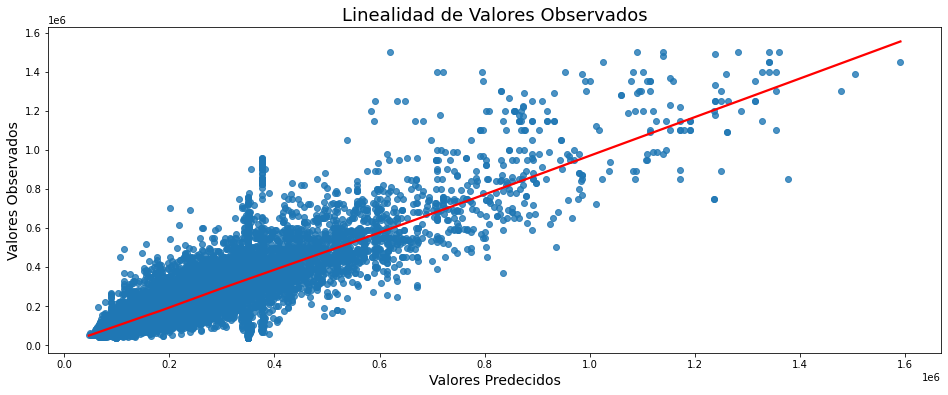

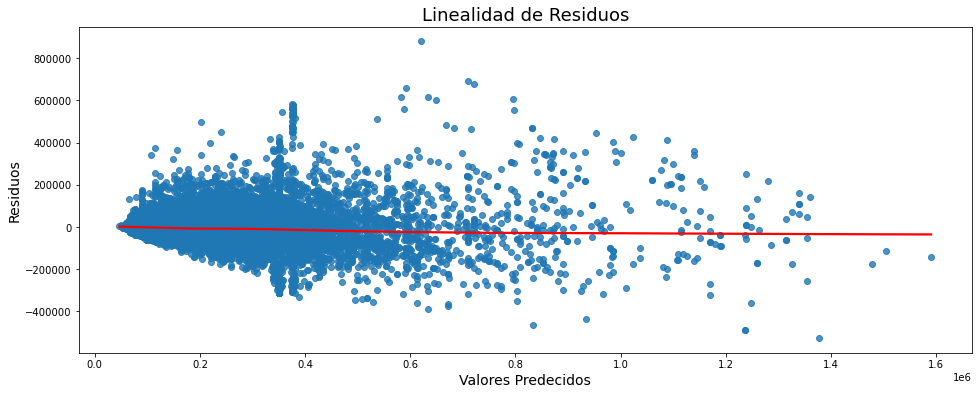

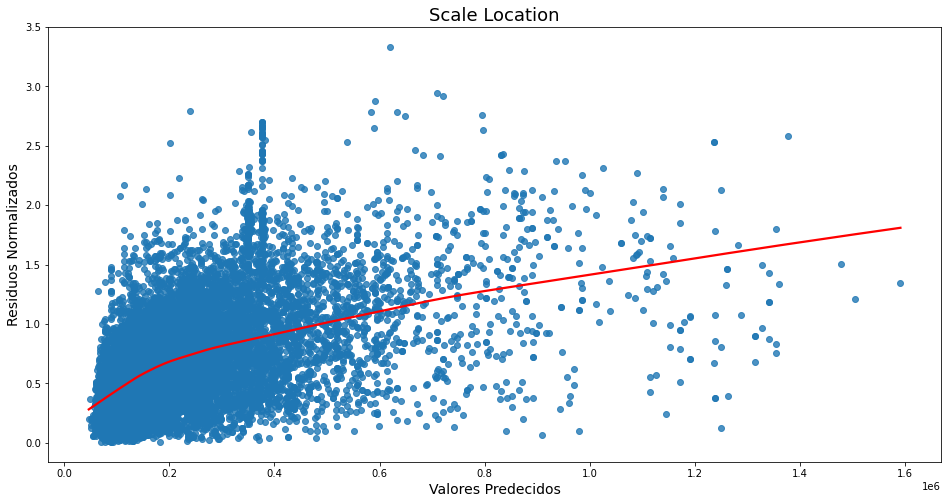

C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


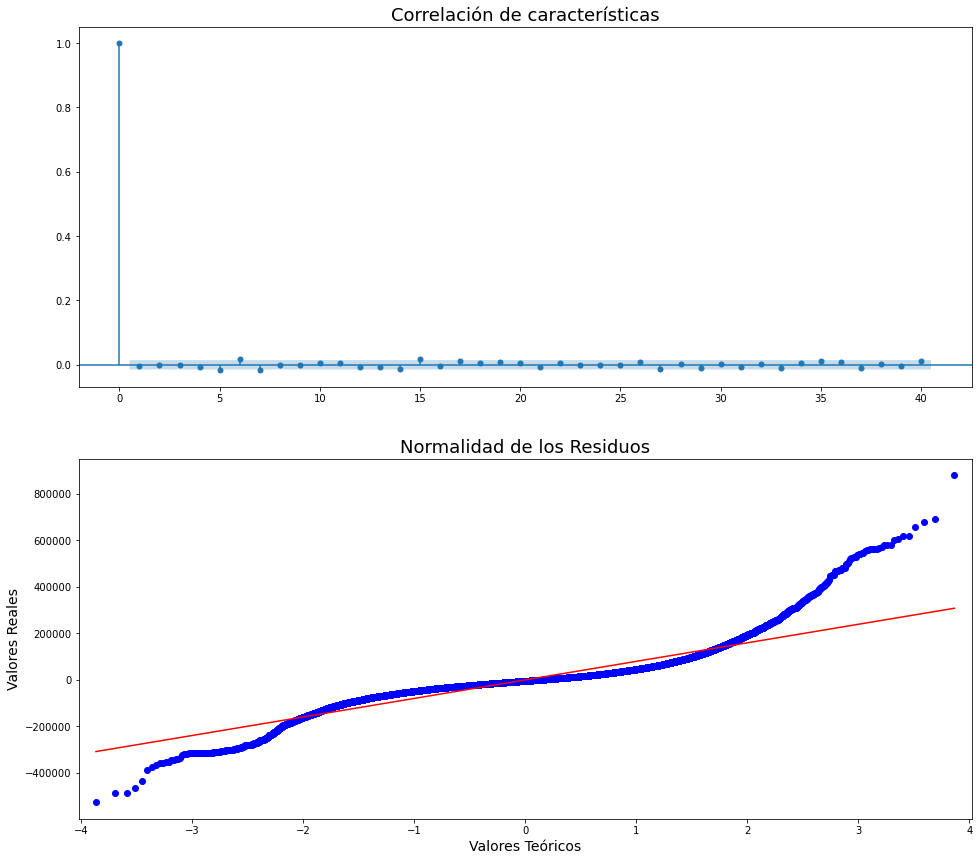

In [51]:
# La siguiente linea de codigo puede activarse para mostrar graficamente la normalidad de los residuos.
gauss_markov_test(X_test_new, y_test_new)

<div class="alert alert-info" role="alert">
<b>6) Compare: Principales conclusiones</b> 
</div>

   
   - Se desarrolla un modelo de regresión lineal con r2_adjusted cercano a 80%.
   
   - El modelo tiene un buen r2 ajustado tanto en Train como en Test. Por lo tanto, no es necesario regularizar. 
   
   - Notamos que el RMSE da un valor alto en relación con la variable target, lo que nos indicaría que deberíamos probar otro tipo de modelo. 
   
   - Mejoramos el modelo "baseline" al disminuir el RMSE y aumentar el r2_ajustado
   
   

In [50]:
#Traemos statsmodel para hacer una regresión linear ordinaria.
from statsmodels.regression import linear_model as sm_linear_model
model_sm_new = sm_linear_model.OLS(y_train_new, sm.add_constant(X_train_new)).fit()

#La siguiente linea de codigo puede activarse para mostrar estadística de la regresión.
model_sm_new.summary()

C:\Users\jtentor\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 precio   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     1489.
Date:                Thu, 12 May 2022   Prob (F-statistic):               0.00
Time:                        19:36:45   Log-Likelihood:            -4.2539e+05
No. Observations:               33413   AIC:                         8.509e+05
Df Residuals:                   33330   BIC:                         8.516e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                     2.127e+05    448.355    474.298      0.000    2.12e+05    2.14e+05
place_name_Adrogué                        5704.0667   1041.524      5.477      0.000    3662.642    7745.491
place_name_Barracas                       3628.0060    724.039      5.011      0.000    2208.863    5047.149
place_name_Barrio Los Alisos             -2300.8081    738.160     -3.117      0.002   -3747.627    -853.989
place_name_Belgrano                       3586.4422    739.622      4.849      0.000    2136.757    5036.127
place_name_Bella Vista                    -855.1605    912.386     -0.937      0.349   -2643.469     933.148
place_name_Benavidez                      5119.5728   1352.244      3.786      0.000    2469.127    7770.019
place_name_Boedo                          3.419e+04    661.905     51.659      0.000    3.29e+04    3.55e+04
place_name_Castelar                       1456.0830    927.780      1.569      0.117    -362.398    3274.564
place_name_Córdoba                        1.902e+16   6.28e+16      0.303      0.762   -1.04e+17    1.42e+17
place_name_Escobar                        4148.4303   1422.919      2.915      0.004    1359.460    6937.401
place_name_Florida                        3677.4905    816.271      4.505      0.000    2077.570    5277.411
place_name_General San Martín               82.6383    853.453      0.097      0.923   -1590.160    1755.436
place_name_Ituzaingó                      1206.5488   1110.250      1.087      0.277    -969.581    3382.679
place_name_La Lucila                      7283.6231    642.261     11.341      0.000    6024.768    8542.478
place_name_La Plata                      -1500.6640   1062.120     -1.413      0.158   -3582.457     581.129
place_name_Lanús                          1203.8236    969.844      1.241      0.215    -697.105    3104.753
place_name_Lomas de Zamora                1801.0744   1012.489      1.779      0.075    -183.439    3785.588
place_name_Martínez                       1.327e+04    778.357     17.044      0.000    1.17e+04    1.48e+04
place_name_Mataderos                      1255.9569    756.450      1.660      0.097    -226.712    2738.626
place_name_Morón                           467.7731    909.620      0.514      0.607   -1315.114    2250.660
place_name_Nordelta                      -4819.0438    740.789     -6.505      0.000   -6271.016   -3367.071
place_name_Nuñez                            45.5149    745.660      0.061      0.951   -1416.004    1507.034
place_name_Olivos                          1.26e+04    792.784     15.895      0.000     1.1e+04    1.42e+04
place_name_Palermo                        2564.6601    838.742      3.058      0.002     920.696    4208.624
place_name_Palermo Soho        